# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names


https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py

## Import packages

In [28]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists_lin_feat_df_withoutuserfeat_allcomments.pkl")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 103888 entries, body to mrc_pmean
dtypes: float64(87790), int64(16092), object(6)
memory usage: 1.2+ GB


In [ ]:
# predictors = df.columns.tolist()
# i = 0
# predictorsfile=open('predictorslist.txt','w')
# # predictorsfile.writelines(predictors)
# for element in predictors:
#     predictorsfile.write(str(i))
#     predictorsfile.write(" ")
#     predictorsfile.write(element)
#     predictorsfile.write('\n')
#     i+=1
# predictorsfile.close()

In [3]:
# multilevel columns

lst1 = (5)*["data"]
lst9 = (15-5)*["traits"]
lst10 = ["data"]
lst2 = (21-17)*["global"]
lst3 = (45-21)*["time"]
lst4 = (16103-45)*["subreddits"]
lst5 = (16116-16103)*["extra_features"]
lst6 = (96308-16116)*["word_ngrams"]
lst7 = (103829-96308)*["char_ngrams"]
lst8 = (103889-103829)*["wordlists"]
headers = lst1 + lst9  + lst10 + lst2 + lst3 + lst4 +lst5 + lst6 + lst7 + lst8 
columns = df.columns.values
print(len(headers))
print(len(columns))
arrays = [headers] + [columns]
df.columns=pd.MultiIndex.from_arrays(arrays)

103888
103888


In [4]:
df['traits', 'agree5'] = df['traits', 'agreeableness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'openn5'] = df['traits', 'openness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'consc5'] = df['traits', 'conscientiousness'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'extra5'] = df['traits', 'extraversion'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))
df['traits', 'neuro5'] = df['traits', 'neuroticism'].apply(lambda x: 0 if x<20 else(1 if x>19 and x<40 else(2 if x>39 and x<60 else(3 if x>59 and x<80 else 4))))

In [5]:
df = df.dropna(axis=0, how='all')
df = df.dropna(axis=1, how='all')

In [6]:
smalldf = df[['traits', 'global', 'time', 'extra_features', 'word_ngrams', 'char_ngrams', 'wordlists']]
smalldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   (traits, agreeableness)            1606 non-null   float64
 1   (traits, openness)                 1583 non-null   float64
 2   (traits, conscientiousness)        1600 non-null   float64
 3   (traits, extraversion)             1603 non-null   float64
 4   (traits, neuroticism)              1599 non-null   float64
 5   (traits, agree)                    1606 non-null   int64  
 6   (traits, openn)                    1606 non-null   int64  
 7   (traits, consc)                    1606 non-null   int64  
 8   (traits, extra)                    1606 non-null   int64  
 9   (traits, neuro)                    1606 non-null   int64  
 10  (traits, agree5)                   1606 non-null   int64  
 11  (traits, openn5)                   1606 non-null  

In [7]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['traits', 'openness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['traits', 'conscientiousness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['traits', 'extraversion'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['traits', 'agreeableness'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['traits', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

## Trait

In [8]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'traits'], axis=1, level=0)
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
    
        if trait_name == 'agreeableness':
            y = df['traits', 'agree']
        elif trait_name == 'openness':
            y = df['traits', 'openn']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro']   
    elif classes=='multi':
        if trait_name == 'agreeableness':
            y = df['traits', 'agree5']
        elif trait_name == 'openness':
            y = df['traits', 'openn5']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'consc5']
        elif trait_name == 'extraversion':
            y = df['traits', 'extra5']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuro5'] 
    elif classes=='linear':
        if trait_name == 'agreeableness':
            y = df['traits', 'agreeableness']
        elif trait_name == 'openness':
            y = df['traits', 'openness']
        elif trait_name == 'conscientiousness':
            y = df['traits', 'conscientiousness']
        elif trait_name == 'extraversion':
            y = df['traits', 'extraversion']
        elif trait_name == 'neuroticism':
            y = df['traits', 'neuroticism']  
    return x,y 

## Classifier

In [ ]:
# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train, classifier, num_feat, weighted):
    if weighted==True: 
        if classifier == "log":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(class_weight='balanced', max_iter = 200, n_jobs=-1))
            ])
        elif classifier == "multilog":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              
              ('classification', LogisticRegression(class_weight='balanced', multi_class='multinomial', 
                                                    max_iter = 200, solver='lbfgs', n_jobs=-1))
            ])
        elif classifier == "svm":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', svm.SVC(class_weight='balanced', max_iter = 1000))
            ])

    else:
        if classifier == "log":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(max_iter = 200, n_jobs=-1))
            ])
        elif classifier == "multilog":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LogisticRegression(multi_class='multinomial', max_iter = 200, solver='lbfgs', 
                                                    n_jobs=-1))
            ])
        elif classifier == "mlp":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', MLPClassifier(hidden_layer_sizes=(3,)))
            ])
        elif classifier == "svm":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', svm.SVC(max_iter = 1000))
            ])
        elif classifier == "svmlinear":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', svm.LinearSVC(max_iter = 1000))
            ])
        elif classifier == "knn":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', KNeighborsClassifier(n_neighbors=1, n_jobs=-1))
            ])
        elif classifier == "linear":
            pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
              ('classification', LinearRegression(n_jobs=-1))
            ])
    return pipeline

## Get names of 30 most important features

In [9]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names
# names = get_names(logpipe)
# print(names)

### Get p-values

In [10]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [11]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [26]:
def create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed):
    cnfpipe_matrix = confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrixcmap=plt.cm.Blues, normalize=normalize)
#     disp.plot() 
    if detailed:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sumpositive = tp + fn
        sumnegative = fp + tn
        sumcorrect = tp + tn
        sumwrong = fp + fn
        sumall = tn+fp+fn+tp
        print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
              sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
              sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
              "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)

    if plotting:
#         %matplotlib inline
#         class_names=[0,1] # name  of classes
#         fig, ax = plt.subplots()
#         tick_marks = np.arange(len(class_names))
#         plt.xticks(tick_marks, class_names)
#         plt.yticks(tick_marks, class_names)
#         # create heatmap
#         sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#         ax.xaxis.set_label_position("bottom")
#         disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix, cmap=plt.cm.Blues, normalize=normalize)
#         disp.plot() 
        plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
#         disp.ax_.set_title('Confusion matrix')
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
#         disp.plot() 
        plt.show()
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

## ROC Curve

In [13]:
def roc_aucscore(clf, x_test, y_test, classes, plotting, detailed):
    if detailed:
        print(roc_auc_score(y, clf.predict_proba(x), multi_class='ovo'))
        return score
    
    if plotting and classes == 'binary':
        plot_roc_curve(clf, x_test, y_test)
        plt.title('ROC Curve', y=1.1)
        plt.show()

# Wrapper


nested stratified cv:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

https://weina.me/nested-cross-validation/


https://towardsdatascience.com/nested-cross-validation-hyperparameter-optimization-and-model-selection-5885d84acda
https://gist.github.com/krsatyam1996/9640ed8baa20d3dc11822564710a8d71#file-nested_cv-py

In [14]:
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']

def switching(trait):
    switcher={
            'openness':30,
            'conscientiousness': 30,
            'agreeableness': 30,
            'extraversion': 30,
            'neuroticism':30
         }
    return switcher.get(trait,"Invalid")

In [ ]:
def classify(df, classifier, classes, trainscores=False, plotting = False, weighted = False, detailed=False):
    for trait_name in traits:
        num_feat = switching(trait_name)
        print("Trait to predict: ", trait_name)
        x,y = trait(df, classes,trait_name)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
#         scores = cross_val_scores(pipeline,X_train,y_train,cv=5,scoring='f1_macro')
        if trainscores:
            x_test = x_train
            y_test = y_train
        if detailed: 
            print("Number of authors in y_train: ", len(y_train))
            print("Number of authors in y_test: ", len(y_test))
        clf = create_pipeline(x_train, y_train, classifier, num_feat, weighted)
        clf.fit(x_train, y_train)
        y_pred=clf.predict(x_test)
        if classes=='linear':
            print("Score (Reg: r sqared, SVM: accuracy): ", clf.score(x_test, y_test))
#             print(y_pred)    
        else:
            if detailed:
                print("Number of authors in y_pred: ", len(y_pred))
                names = get_names(x, clf)
                print("Names of the top", len(names), "features: \n", names, "\n")
                pvalues = get_pvalues(clf, x)
            #     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
                if trait_name=="openness":
                    count = pvalues['pvalue'].le(0.02).sum()
                if trait_name=="conscientiousness":
                    count = pvalues['pvalue'].le(0.07).sum()
                if trait_name=="extraversion":
                    count = pvalues['pvalue'].le(0.05).sum()
                if trait_name=="agreeableness":
                    count = pvalues['pvalue'].le(0.04).sum()
                if trait_name=="neuroticism":
                    count = pvalues['pvalue'].le(0.04).sum()
                print("Number of features with this threshold: ", count)
        #         print("\nP-Values: \nNumber of features: ", 30)
        #         print(pvalues.nsmallest(count,'pvalue'))
                print("\n")
            report = scores(y_test, y_pred, "report")
            print("Classification report: \n", report)
            if plotting: 
                cnfmatrix = create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed) 
                rocplot = roc_aucscore(clf, x_test, y_test, classes, plotting, detailed)
        #     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
        #     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
                if (classifier == 'log' and classes == 'binary'):
                    lr_precision, lr_recall = score_plot(clf, y_test, x_test)
            plt.show()
    #     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

## Wrapper with nested stratified cross validation

In [32]:
def create_pipeline_cv(X_train, y_train, classifier, num_feat):
    if classifier == "mcc":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', DummyClassifier(strategy="most_frequent"))
        ])
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', LogisticRegression(class_weight='balanced'))
        ])
    elif classifier == "multilog":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', LogisticRegression(multi_class='multinomial', n_jobs=-1))
        ])
    elif classifier == "mlp":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', MLPClassifier(n_layers_=3))
        ])
    elif classifier == "svm":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', svm.SVC(class_weight='balanced', probability=True))
        ])
    elif classifier == "svmlinear":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', svm.LinearSVC())
        ])
    elif classifier == "knn":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', KNeighborsClassifier(n_neighbors=1, n_jobs=-1))
        ])
    elif classifier == "linear":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('scaler', StandardScaler()),
          ('feature_selection',  SelectKBest(f_classif, k=num_feat)),
          ('classification', LinearRegression(n_jobs=-1))
        ])
    return pipeline

In [38]:
def get_params(classifier):
    if classifier == 'log':
        params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    if classifier == 'multilog':
        params = {'classification__class_weight': [None, 'balanced'], 
                  'classification__solver': ['lbfgs', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000]}
    elif classifier == 'mlp':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)]}
    elif classifier == 'svm':
        params = {'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'classification__gamma': ['scale', 'auto'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    return params
# 'classification__class_weight': ['balanced'], 

clf_lst = ['mcc', 'log', 'mlp', 'svm']

def classify_cv(df, classes):
    for option in tqdm(clf_lst):
        print("Classifier: ", option, "\n")
        for trait_name in tqdm(traits):
            num_feat = switching(trait_name)
            print("\nTrait to predict: ", trait_name, "\n")
            x,y = trait(df, classes, trait_name)
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

            if option == 'log':
                inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
            if option == 'svm' or option == 'mlp':
                inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
            outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

            pipeline = create_pipeline_cv(X_train, y_train, option, num_feat)
            if option == 'log' or option == 'svm' or option=='mlp':
                t0 = time()
                print("\tStart grid search (inner cv)...")
                params = get_params(option)
                clf = GridSearchCV(estimator=pipeline, param_grid=params, scoring='f1_macro', n_jobs=-1, cv=inner_cv)
                clf.fit(X_train, y_train)
                print("\tGrid search done in %0.3fs" % (time() - t0))

                best_model = clf.best_estimator_
                print("\tBest model: ", best_model)
                t1 = time()
                print("\tStart cross validation (outer)...")
                nested_score = cross_val_score(clf, X=X_train, y=y_train, scoring='f1_macro', n_jobs=-1, cv=outer_cv)
                print("\tCross_val_score calculated in %0.3fs" % (time() - t1))
                score = nested_score.mean()
                print("Score: ", score)
            else:
                best_model = pipeline
                t0 = time()
                print("\tStart cross validation...")
                nested_score = cross_val_score(pipeline, X=X_train, y=y_train, scoring='f1_macro', n_jobs=-1, cv=outer_cv)
                print("\tCross_val_score calculated in %0.3fs" % (time() - t0))
                score = nested_score.mean()
                print("Score: ", score)
            
            print("Computing final model...")
            model = best_model.fit(X_train, y_train)
            names = get_names(x, model)
            print("Names of the top", len(names), "features: \n", names, "\n")
            y_pred_prob = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)
            print("AUC", roc_auc_score(y_test, y_pred_prob))
            report = scores(y_test, y_pred, "report")
            print("Classification report: \n", report) 
            cnfmatrix = create_cnfmatrix(model, X_test, y_test, y_pred, plotting=True, detailed=False) 
            rocplot = roc_aucscore(model, X_test, y_test, classes, plotting=True, detailed=False)
            plt.show()
#         cv_outer = StratifiedKFold(n_splits=5)
#         cv_outer_lst = cv_outer.split(X_train, y_train)

#         for train_idx, val_idx in tqdm(cv_outer_lst):
#             train_data, val_data = X_train.iloc[train_idx], X_train.iloc[val_idx]
#             train_target, val_target = y_train[train_idx], y_train[val_idx]


#             print("\n\tCreate pipeline with", classifier, "...")
#             clf = create_pipeline_cv(X_train, y_train, classifier, num_feat)
#             cv_inner = StratifiedKFold(n_splits=5)
#             params = get_params(classifier)
#             print("\tStart grid search...")
#             t0 = time()
#             gd_search = GridSearchCV(clf, params, scoring='f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
#             print("\tGrid search done in %0.3fs" % (time() - t0))
#             print("\tGet best model...")
#             best_model = gd_search.best_estimator_
#             print(best_model)

#             print("\tFit best model...")
#             clfnew = best_model.fit(train_data, train_target)
#             y_pred_prob = clfnew.predict_proba(val_data)[:,1]
#             y_pred = clfnew.predict(val_data)
#             f1_macro = f1_score(val_target, y_pred, average='macro')

#             print("Val Acc:",f1_macro , "Best GS Acc:",gd_search.best_score_, "Best Params:",gd_search.best_params_)


          # Training final model



  0%|          | 0/4 [00:00<?, ?it/s]

Classifier:  mcc 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 

	Start cross validation...
	Cross_val_score calculated in 3.302s
Score:  0.41900436044070927
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',                'idilik'),
            ('subreddits',           'electroneum'),
            ('subreddits',        'sidewayslanter'),
            ('subreddits',                'gotham'),
            ('subreddits',           'classicrock'),
            ('subreddits',                'bogota'),
            ('subreddits',                   'zen'),
            ('subreddits',             'mholbills'),
            ('subreddits',                  'osmc'),
            ('subreddits',    'u_eloquentsolitude'),
            ('subreddits',       'nkwinsthethrone'),
            ('subreddits',             'fuckramos'),
            ('subreddits',                   'ask'),
            ('subreddits',          'arianagrande'),
            ('subreddits',               'peloton'),
            ('subreddits

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


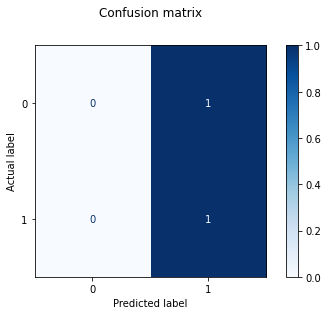

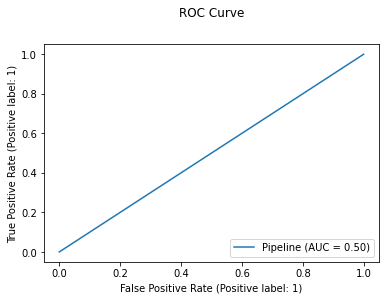


Trait to predict:  conscientiousness 

	Start cross validation...
	Cross_val_score calculated in 1.973s
Score:  0.3829883396341315
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',                'gunnm'),
            ('subreddits',          'aznidentity'),
            ('subreddits',            'trapmetal'),
            ('subreddits',   'monsterhunterworld'),
            ('subreddits',          'sleepycabin'),
            ('subreddits',            'beatsaber'),
            ('subreddits',        'onetrueemilia'),
            ('subreddits',          'mangonewild'),
            ('subreddits',               'robots'),
            ('subreddits',          'casualgames'),
            ('subreddits',        'learnmandarin'),
            ('subreddits',            'billboard'),
            ('subreddits',        'netflixviavpn'),
            ('subreddits',                'egypt'),
            ('subreddits',               'fakeid'),
            ('subreddits', 'gov

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


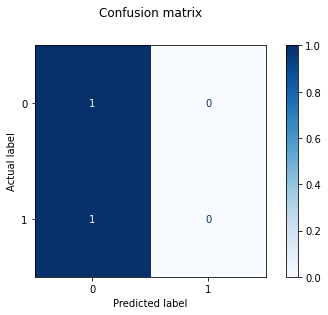

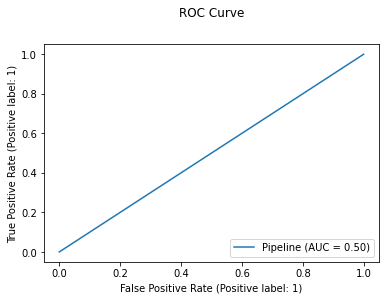


Trait to predict:  extraversion 

	Start cross validation...
	Cross_val_score calculated in 1.931s
Score:  0.3903128197953203
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',       'subredditsmeet'),
            ('subreddits',                'kafka'),
            ('subreddits',      'creepyoffbrands'),
            ('subreddits',      'nonetneutrality'),
            ('subreddits',        'mstormontvote'),
            ('subreddits',      'unexpectedjihad'),
            ('subreddits',           'neoliberal'),
            ('subreddits',    'thechurchofrogers'),
            ('subreddits',             'duckgame'),
            ('subreddits',     'thisismylifemeow'),
            ('subreddits',         'dfwgardening'),
            ('subreddits',      'openthelastmile'),
            ('subreddits',         'wholesomebpt'),
            ('subreddits',         'whiskeytribe'),
            ('subreddits',               'meteor'),
            ('subreddits',       'fo

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


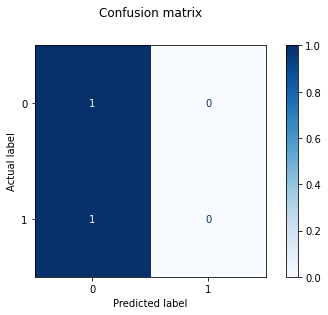

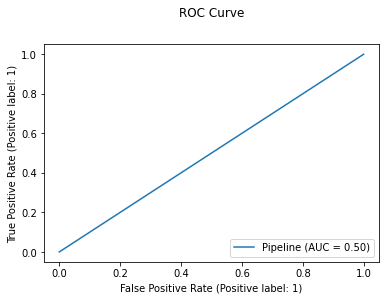


Trait to predict:  agreeableness 

	Start cross validation...
	Cross_val_score calculated in 1.855s
Score:  0.3605572139303483
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',                   'mtf'),
            ('subreddits',               'konmari'),
            ('subreddits',              'selenium'),
            ('subreddits',             'houseporn'),
            ('subreddits',       'battlefield_one'),
            ('subreddits',          'senrankagura'),
            ('subreddits',                  'acne'),
            ('subreddits',                'premed'),
            ('subreddits',            'policy2015'),
            ('subreddits',              'airforce'),
            ('subreddits',                 'egypt'),
            ('subreddits', 'talesfromthefrontdesk'),
            ('subreddits',         'ruinedorgasms'),
            ('subreddits',             'biomutant'),
            ('subreddits',             'japanpics'),
            ('subred

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


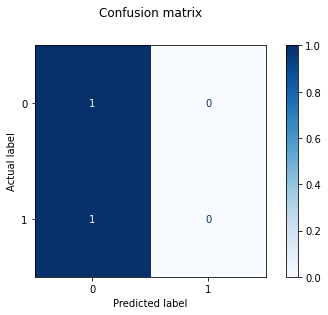

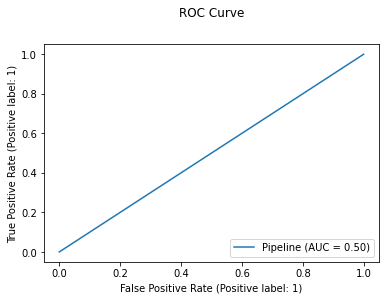


Trait to predict:  neuroticism 

	Start cross validation...
	Cross_val_score calculated in 1.443s
Score:  0.33711829507329644
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',         'atlantaunited'),
            ('subreddits',         'destinysherpa'),
            ('subreddits',                'ballet'),
            ('subreddits', 'piratesofthecaribbean'),
            ('subreddits',          'mysterymedia'),
            ('subreddits',               'topgear'),
            ('subreddits',       'furrywallpapers'),
            ('subreddits',    'androgynoushotties'),
            ('subreddits',           'baneposting'),
            ('subreddits',        'galacticsenate'),
            ('subreddits',               'editors'),
            ('subreddits',    'upvotedbecausegirl'),
            ('subreddits',      'pandoranredcross'),
            ('subreddits',         'absoluteunits'),
            ('subreddits',             'arabfunny'),
            ('subredd

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


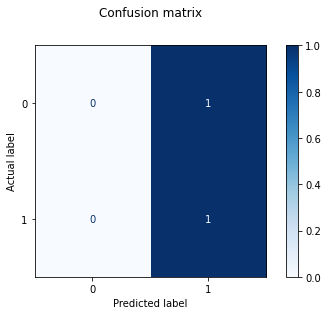

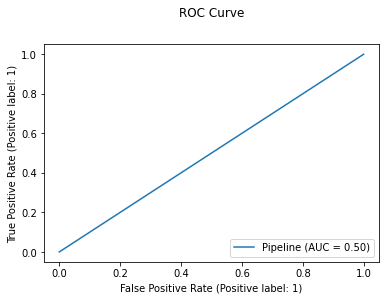

Classifier:  log 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 209.513s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced',
                                    solver='saga'))])
	Start cross validation (outer)...
	Cross_val_score calculated in 745.996s
Score:  0.4891459396293687
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Names of the top 30 features: 
 MultiIndex([('subreddits',             'keurig'),
            ('subreddits', 'fuckunitedairlines'),
            ('subreddits',         'chromeapps'),
            ('subreddits',            'siacoin'),
            ('subreddits',             'skate3'),
            ('subreddits', 'u_eloquentsolitude'),
            ('subreddits',         'raimimemes'),
            ('subreddits',             'albany'),
            ('subreddits',        'gamephysics'),
            ('subreddits',          'gaydorado'),
            ('subreddits',          'shitnssay'),
            ('subreddits',          'marcopolo'),
            ('subreddits',         'flat_earth'),
            ('subreddits',           'workflow'),
            ('subreddits',          'doommetal'),
            ('subreddits',         'backpacker'),
            ('subreddits',              'n_b_p'),
            ('subreddits',           'shpongle'),
            ('subreddits',   'iwanttoapologize'),
            ('subr

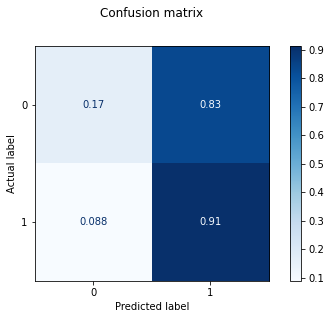

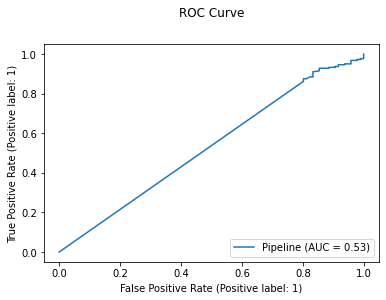


Trait to predict:  conscientiousness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 215.576s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=200,
                                    solver='saga'))])
	Start cross validation (outer)...
	Cross_val_score calculated in 748.144s
Score:  0.46470761065774724
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Names of the top 30 features: 
 MultiIndex([(      'time',                 '2017'),
            ('subreddits',          'overlanding'),
            ('subreddits',               'gentoo'),
            ('subreddits', 'warhammerunderworlds'),
            ('subreddits',                 'ween'),
            ('subreddits',               'motola'),
            ('subreddits',              'ukraine'),
            ('subreddits',     'onetruthprevails'),
            ('subreddits',              'trumpet'),
            ('subreddits',              'meumeta'),
            ('subreddits',            'raincomic'),
            ('subreddits',            'wowaddons'),
            ('subreddits',        'gameofthrones'),
            ('subreddits',         '13reasonswhy'),
            ('subreddits',              'reckful'),
            ('subreddits',                 'bbuk'),
            ('subreddits',               'mini14'),
            ('subreddits',             'starbomb'),
            ('subreddits',      

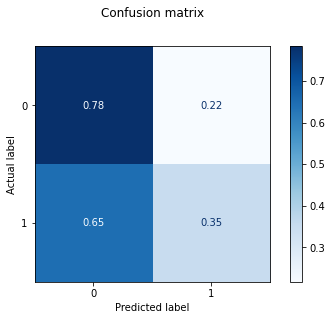

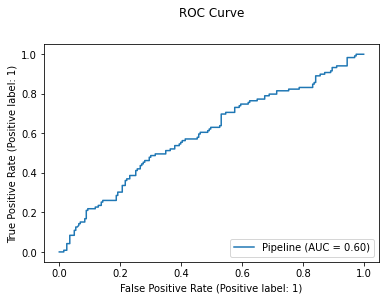


Trait to predict:  extraversion 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Grid search done in 214.501s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, solver='saga'))])
	Start cross validation (outer)...
	Cross_val_score calculated in 736.827s
Score:  0.5205303932636969
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Names of the top 30 features: 
 MultiIndex([('subreddits',                   'i2p'),
            ('subreddits',           'ketoscience'),
            ('subreddits',             'full_news'),
            ('subreddits',  'nocontext_wallpapers'),
            ('subreddits',              'titanstv'),
            ('subreddits',                'tinder'),
            ('subreddits',    'anarchoslacktivism'),
            ('subreddits',                'latvia'),
            ('subreddits',                'mega64'),
            ('subreddits',             'humanporn'),
            ('subreddits',                'rstats'),
            ('subreddits',         'shotglassbets'),
            ('subreddits',             'pykemains'),
            ('subreddits',              'workflow'),
            ('subreddits',               'dashpay'),
            ('subreddits',           'colorizebot'),
            ('subreddits',            'europefire'),
            ('subreddits',      'confrontingchaos'),
            ('

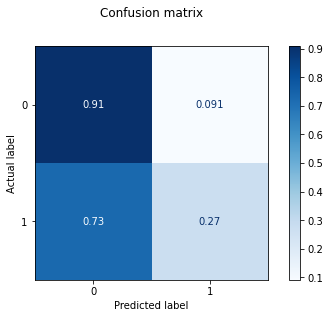

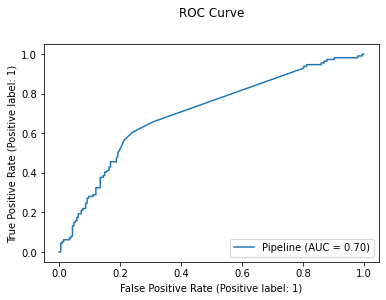


Trait to predict:  agreeableness 

	Start grid search (inner cv)...
	Grid search done in 213.324s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000, solver='saga'))])
	Start cross validation (outer)...
	Cross_val_score calculated in 745.244s
Score:  0.5508958042804565
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',         'putaneggonit'),
            ('subreddits',       'cielestialtest'),
            ('subreddits',                 'chat'),
            ('subreddits',                 'fcpx'),
            ('subreddits',         'youngjustice'),
            ('subreddits', 'marinaandthediamonds'),
            ('subreddits',              'gwnerdy'),
            ('subreddits'

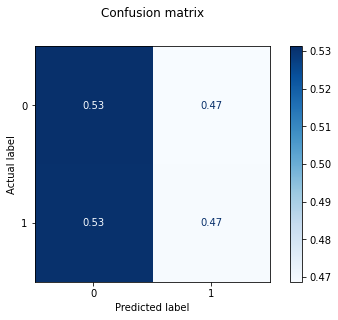

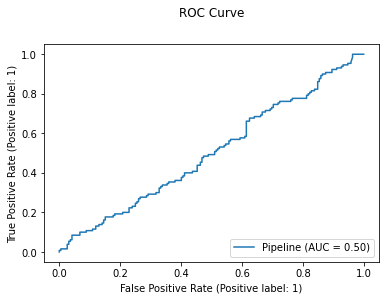


Trait to predict:  neuroticism 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Grid search done in 210.234s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 LogisticRegression(C=100, class_weight='balanced'))])
	Start cross validation (outer)...
	Cross_val_score calculated in 740.342s
Score:  0.5187360789941063
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Names of the top 30 features: 
 MultiIndex([('subreddits',            'pokemonnox'),
            ('subreddits',                   'tzm'),
            ('subreddits',               'yankees'),
            ('subreddits',               'playtbc'),
            ('subreddits',                   'zen'),
            ('subreddits',               'outlier'),
            ('subreddits',                'ottawa'),
            ('subreddits',                  'coss'),
            ('subreddits',                 'weeds'),
            ('subreddits',              'chanceme'),
            ('subreddits',    'furrypornsubreddit'),
            ('subreddits',            'filmstruck'),
            ('subreddits',          'upstateurban'),
            ('subreddits',               'medizzy'),
            ('subreddits',              'bodymods'),
            ('subreddits',            'sainsburys'),
            ('subreddits',              'celticfc'),
            ('subreddits',        'schizoiddating'),
            ('

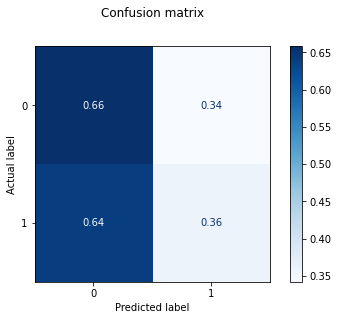

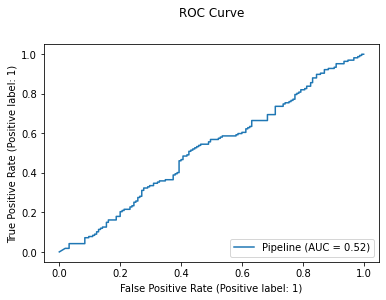

Classifier:  mlp 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 

	Start grid search (inner cv)...
	Grid search done in 11.718s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(200,)))])
	Start cross validation (outer)...
	Cross_val_score calculated in 41.113s
Score:  0.46767746566800705
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Names of the top 30 features: 
 MultiIndex([('subreddits',             'vocaloid'),
            ('subreddits',      'latterdaysaints'),
            ('subreddits',          'scifiscroll'),
            ('subreddits',    'moviesinthemaking'),
            ('subreddits',        'vegetarianism'),
            ('subreddits',      'killyourconsole'),
            ('subreddits',            'trumpgret'),
            ('subreddits',          'makemesmile'),
            ('subreddits',          'synesthesia'),
            ('subreddits',  'blackmidiskyscraper'),
            ('subreddits',           'hotpeppers'),
            ('subreddits',           'sainsburys'),
            ('subreddits', 'silphroadaustralasia'),
            ('subreddits',      'learnjavascript'),
            ('subreddits',             'thebeach'),
            ('subreddits',         'bassethounds'),
            ('subreddits',            'melbourne'),
            ('subreddits',                'kanye'),
            ('subreddits',      

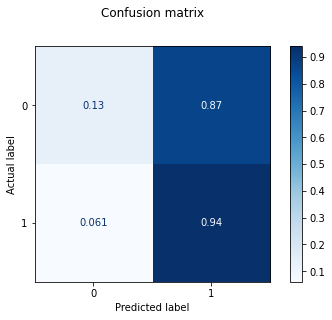

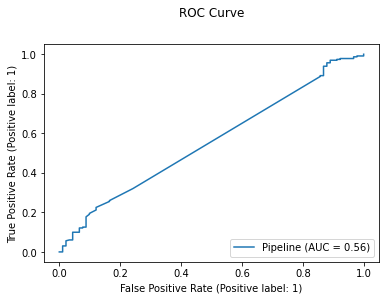


Trait to predict:  conscientiousness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 11.401s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(50,)))])
	Start cross validation (outer)...
	Cross_val_score calculated in 45.953s
Score:  0.490367108245799
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Names of the top 30 features: 
 MultiIndex([('subreddits',            'elitewings'),
            ('subreddits',         'asklosangeles'),
            ('subreddits',                 'fonts'),
            ('subreddits',         'bestofnetflix'),
            ('subreddits',           'cyanogenmod'),
            ('subreddits',              'daughter'),
            ('subreddits',  'thegirlsurvivalguide'),
            ('subreddits',        'travelpartners'),
            ('subreddits',                  'genz'),
            ('subreddits',          'uraniumglass'),
            ('subreddits',  'recreationtianeptine'),
            ('subreddits',   'sverigedemokraterna'),
            ('subreddits',       'dirtyconfession'),
            ('subreddits',          'robocrafters'),
            ('subreddits',         'tagprotesting'),
            ('subreddits',                 'cpucs'),
            ('subreddits',           'ovalnipples'),
            ('subreddits',               'bostonu'),
            ('

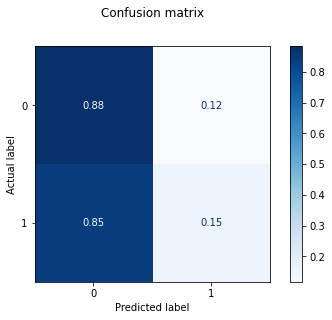

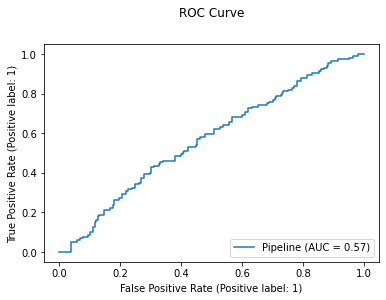


Trait to predict:  extraversion 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 14.936s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Start cross validation (outer)...
	Cross_val_score calculated in 45.615s
Score:  0.5318132049669593
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Names of the top 30 features: 
 MultiIndex([('subreddits',             'breadit'),
            ('subreddits',             'thewire'),
            ('subreddits',        'adoptasilver'),
            ('subreddits',      'fashionlancers'),
            ('subreddits',         'learnpython'),
            ('subreddits',  'genetic_algorithms'),
            ('subreddits',              'pop_os'),
            ('subreddits',        'fyrefestival'),
            ('subreddits',         'battlefront'),
            ('subreddits',         'orphanblack'),
            ('subreddits',        'programmatic'),
            ('subreddits',           'houseporn'),
            ('subreddits', 'relationship_advice'),
            ('subreddits',      'totalwarhammer'),
            ('subreddits',       'whatsthisbird'),
            ('subreddits',          'otomegames'),
            ('subreddits',             'mlplite'),
            ('subreddits',             'scifitv'),
            ('subreddits',             'kpopfap'),

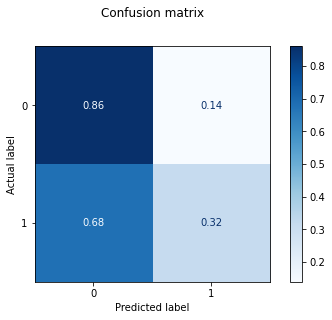

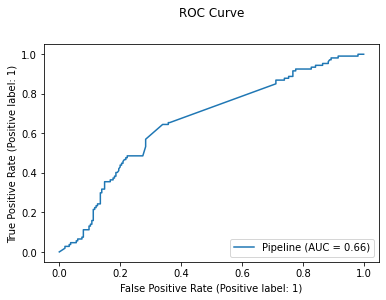


Trait to predict:  agreeableness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 15.664s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Start cross validation (outer)...
	Cross_val_score calculated in 46.784s
Score:  0.4649388700837197
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Names of the top 30 features: 
 MultiIndex([('subreddits', 'modelinnocenceproject'),
            ('subreddits',         'nintendokaren'),
            ('subreddits',               'falcons'),
            ('subreddits',         'tatwdspoilers'),
            ('subreddits',                'chrome'),
            ('subreddits',          'messandnoise'),
            ('subreddits',         'retrofuturism'),
            ('subreddits', 'memetemplatesofficial'),
            ('subreddits',            'incorgnito'),
            ('subreddits',  'traaaaaaannnnnnnnnns'),
            ('subreddits',               'witcher'),
            ('subreddits',           'datascience'),
            ('subreddits',      'guitarcirclejerk'),
            ('subreddits',             'zuckmemes'),
            ('subreddits',              'adjuncts'),
            ('subreddits',          'ebonyinheels'),
            ('subreddits',          'incelsadvice'),
            ('subreddits',    'modelromanrepublic'),
            ('

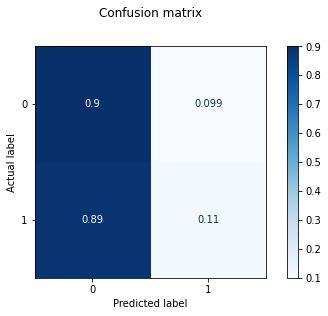

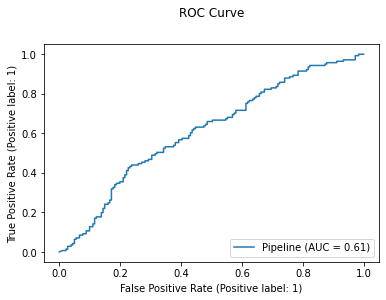


Trait to predict:  neuroticism 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


	Grid search done in 14.620s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification', MLPClassifier(hidden_layer_sizes=(500,)))])
	Start cross validation (outer)...
	Cross_val_score calculated in 46.257s
Score:  0.48262251490264346
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Names of the top 30 features: 
 MultiIndex([('subreddits',       'askwomenover30'),
            ('subreddits',             'projared'),
            ('subreddits',          'liverpoolfc'),
            ('subreddits',             'twilight'),
            ('subreddits',                 'k_on'),
            ('subreddits',             'fringers'),
            ('subreddits',           'smallville'),
            ('subreddits',        'festivaltrees'),
            ('subreddits',   'fullmoviesongoogle'),
            ('subreddits',         'thestaircase'),
            ('subreddits',           'budgetfood'),
            ('subreddits',           'craterlake'),
            ('subreddits',           'floridaman'),
            ('subreddits',          'interesting'),
            ('subreddits',     'nomansskyanimals'),
            ('subreddits',              'sissies'),
            ('subreddits',           'europefire'),
            ('subreddits',              'laptops'),
            ('subreddits',      

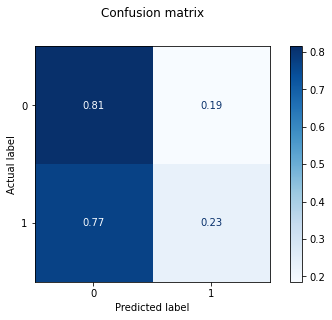

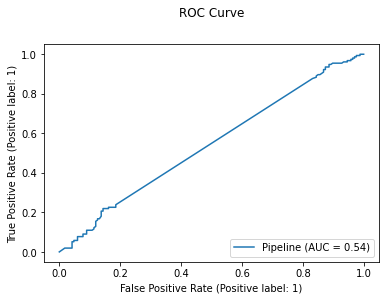

Classifier:  svm 



  0%|          | 0/5 [00:00<?, ?it/s]


Trait to predict:  openness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26667969 0.26667969 0.26909725 0.44693574 0.43596605 0.43418644
 0.43254165 0.44244029 0.30295177 0.30295177 0.26667969 0.23113676
 0.38135913 0.38135913 0.26667969 0.3027323         nan        nan
        nan        nan 0.26667969 0.26667969 0.26909725 0.44693574
 0.43596605 0.43418644 0.43254165 0.44244029 0.30295177 0.30295177
 0.26667969 0.23113676 0.38135913 0.38135913 0.26667969 0.3027323
        nan        nan        nan        nan 0.43246225 0.43246225
 0.43690149 0.44966354 0.43246818 0.43518859 0.43751345 0.440312
 0.30295177 0.30295177 0.26667969 0.37710085 0.38135913 0.38135913
 0.26667969 0.26667969        nan        nan        nan        nan
 0.43246225 0.43246225 0.43690149 0.44966354 0.43246818 0.43518859
 0.43751345 0.440312   0.30295177 0.30295177 0.26667969 0.37710085
 0.38135913 0.38135913 0.26667969 0.26667969  

	Grid search done in 313.269s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=100, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Start cross validation (outer)...
	Cross_val_score calculated in 1088.657s
Score:  0.4902372348671083
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Names of the top 30 features: 
 MultiIndex([('subreddits',         'tattoodesigns'),
            ('subreddits',         'touchthafishy'),
            ('subreddits', 'environmental_science'),
            ('subreddits',            'spongebros'),
            ('subreddits',                'reaper'),
            ('subreddits',                'bulges'),
            ('subreddits',     'soulcrushingjuice'),
            ('subreddits',   'melbournecirclejerk'),
            ('subreddits',          'adventofcode'),
            ('subreddits',                   'mac'),
            ('subreddits',        'unbiasedcanada'),
            ('subreddits',          'redneckfixes'),
            ('subreddits',          'blackskiesrp'),
            ('subreddits',     'recordthisforfree'),
            ('subreddits',          'thickglasses'),
            ('subreddits',           'tricitieswa'),
            ('subreddits',            'potuswatch'),
            ('subreddits',             'projectfi'),
            ('

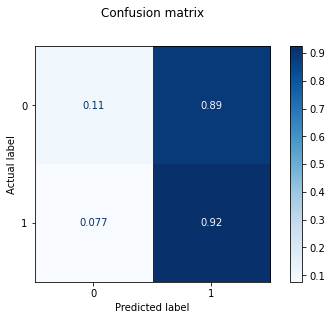

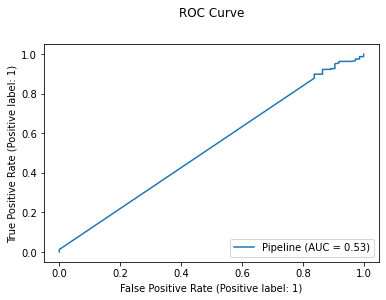


Trait to predict:  conscientiousness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.27925367 0.27925367 0.28065337 0.43539388 0.2820679  0.2820679
 0.28348243 0.41771304 0.27783914 0.27783914 0.29880041 0.27783914
 0.27783914 0.27783914 0.27783914 0.27783914        nan        nan
        nan        nan 0.27925367 0.27925367 0.28065337 0.43539388
 0.2820679  0.2820679  0.28348243 0.41771304 0.27783914 0.27783914
 0.29880041 0.27783914 0.27783914 0.27783914 0.27783914 0.27783914
        nan        nan        nan        nan 0.27985479 0.28497667
 0.28776769 0.45284853 0.28356337 0.28356337 0.28639262 0.43938132
 0.27783914 0.27783914 0.29880041 0.27783914 0.27783914 0.27783914
 0.27783914 0.27783914        nan        nan        nan        nan
 0.27985479 0.28497667 0.28776769 0.45284853 0.28356337 0.28356337
 0.28639262 0.43938132 0.27783914 0.27783914 0.29880041 0.27783914
 0.27783914 0.27783914 0.27783914 0.27783914

	Grid search done in 315.072s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10000, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Start cross validation (outer)...
	Cross_val_score calculated in 1083.295s
Score:  0.5164189991620967
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Names of the top 30 features: 
 MultiIndex([(    'global',      'num_subreddit'),
            (    'global',               'lang'),
            ('subreddits',            'timbers'),
            ('subreddits',          'livestock'),
            ('subreddits',           'snowfall'),
            ('subreddits',     'fredericksburg'),
            ('subreddits', 'austrian_economics'),
            ('subreddits',    'steamhammergame'),
            ('subreddits',       'nerdfighters'),
            ('subreddits',       'onetrueprovo'),
            ('subreddits',          'fuckdruid'),
            ('subreddits',            'thrifty'),
            ('subreddits',      'newvegasmemes'),
            ('subreddits',     'darkestdungeon'),
            ('subreddits',            'whiskey'),
            ('subreddits',   'iwltsobhsidnwtso'),
            ('subreddits',          'buttfangs'),
            ('subreddits',         'theredpill'),
            ('subreddits',         'kaisamains'),
            ('subr

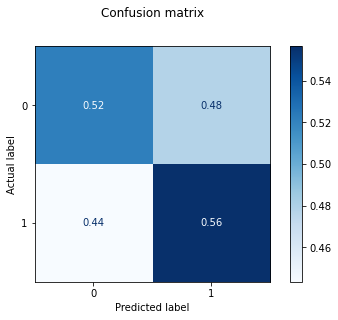

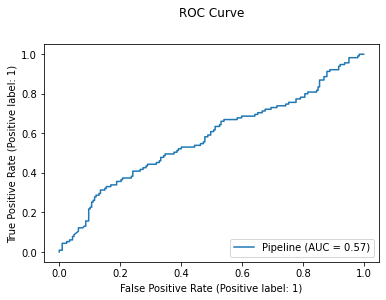


Trait to predict:  extraversion 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.26079287 0.26079287 0.26079287 0.40453646 0.26266983 0.26398932
 0.26266983 0.42412104 0.28698102 0.28698102 0.28698102 0.26079287
 0.26079287 0.26079287 0.26079287 0.26079287        nan        nan
        nan        nan 0.26079287 0.26079287 0.26079287 0.40453646
 0.26266983 0.26398932 0.26266983 0.42412104 0.28698102 0.28698102
 0.28698102 0.26079287 0.26079287 0.26079287 0.26079287 0.26079287
        nan        nan        nan        nan 0.2670876  0.2670876
 0.27192881 0.49013628 0.26487752 0.26531833 0.26442406 0.44377785
 0.28698102 0.28698102 0.28698102 0.35752753 0.26079287 0.26079287
 0.26079287 0.26079287        nan        nan        nan        nan
 0.2670876  0.2670876  0.27192881 0.49013628 0.26487752 0.26531833
 0.26442406 0.44377785 0.28698102 0.28698102 0.28698102 0.35752753
 0.26079287 0.26079287 0.26079287 0.26079287

	Grid search done in 312.844s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10000, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Start cross validation (outer)...
	Cross_val_score calculated in 1076.007s
Score:  0.5785245851377958
Computing final model...
Names of the top 30 features: 
 MultiIndex([('subreddits',        'dwarffortress'),
            ('subreddits',                'greed'),
            ('subreddits',         'makemesuffer'),
            ('subreddits',                 'arma'),
            ('subreddits',            'trapmetal'),
            ('subreddits',       'publicfreakout'),
            ('subreddits',            'full_news'),
            ('subreddits',      'trendingreddits'),
            ('subreddits',           'brasilivre')

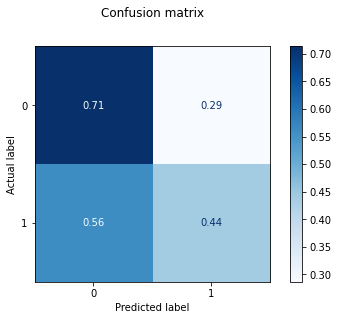

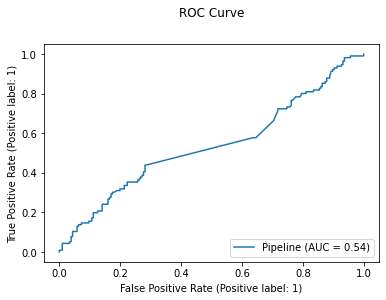


Trait to predict:  agreeableness 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.29912538 0.29912538 0.29912538 0.45705157 0.30927101 0.30775588
 0.30927101 0.38339827 0.31264896 0.29912538 0.31264896 0.29912538
 0.29912538 0.29912538 0.29912538 0.29912538        nan        nan
        nan        nan 0.29912538 0.29912538 0.29912538 0.45705157
 0.30927101 0.30775588 0.30927101 0.38339827 0.31264896 0.29912538
 0.31264896 0.29912538 0.29912538 0.29912538 0.29912538 0.29912538
        nan        nan        nan        nan 0.30961242 0.31260858
 0.31855021 0.47471042 0.31474749 0.31323235 0.31323235 0.38931562
 0.31264896 0.29912538 0.31264896 0.29912538 0.29912538 0.29912538
 0.29912538 0.29874272        nan        nan        nan        nan
 0.30961242 0.31260858 0.31855021 0.47471042 0.31474749 0.31323235
 0.31323235 0.38931562 0.31264896 0.29912538 0.31264896 0.29912538
 0.29912538 0.29912538 0.29912538 0.2987427

	Grid search done in 315.181s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=10000, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Start cross validation (outer)...
	Cross_val_score calculated in 1083.540s
Score:  0.49661224851393915
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Names of the top 30 features: 
 MultiIndex([('subreddits',        'infpcreations'),
            ('subreddits',              'moto360'),
            ('subreddits',             'nyknicks'),
            ('subreddits',          'theohhellos'),
            ('subreddits',    'animalsdoingstuff'),
            ('subreddits',            'modelvice'),
            ('subreddits',             'portugal'),
            ('subreddits',                 'flcl'),
            ('subreddits',        'maitlandward2'),
            ('subreddits',             'collapse'),
            ('subreddits',      'northcarolinafc'),
            ('subreddits',              'clubneo'),
            ('subreddits',               'ukbike'),
            ('subreddits',       'poetry_critics'),
            ('subreddits',            'campbisco'),
            ('subreddits', 'istodayfridaythe13th'),
            ('subreddits',          'mhoctabloid'),
            ('subreddits',          'catsinsinks'),
            ('subreddits',      

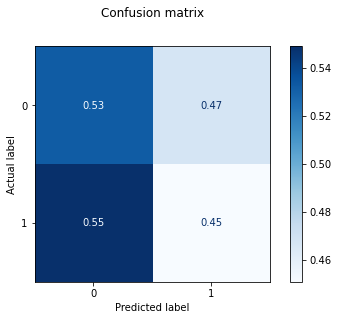

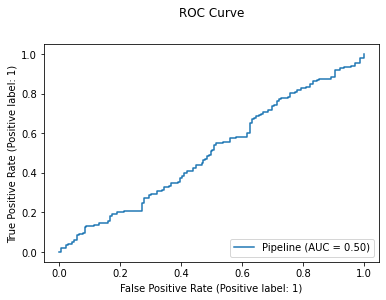


Trait to predict:  neuroticism 

	Start grid search (inner cv)...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.33361956 0.34369135 0.3388838  0.39598498 0.35194685 0.35608085
 0.35196845 0.3604645  0.33016952 0.33016952 0.33016952 0.35815219
 0.33709557 0.33709557 0.33709557 0.338825          nan        nan
        nan        nan 0.33361956 0.34369135 0.3388838  0.39598498
 0.35194685 0.35608085 0.35196845 0.3604645  0.33016952 0.33016952
 0.33016952 0.35815219 0.33709557 0.33709557 0.33709557 0.338825
        nan        nan        nan        nan 0.36872332 0.35759974
 0.37051015 0.44215154 0.35031903 0.35853882 0.36217084 0.36317891
 0.33016952 0.33016952 0.33016952 0.36952092 0.33709557 0.33709557
 0.33709557 0.34058722        nan        nan        nan        nan
 0.36872332 0.35759974 0.37051015 0.44215154 0.35031903 0.35853882
 0.36217084 0.36317891 0.33016952 0.33016952 0.33016952 0.36952092
 0.33709557 0.33709557 0.33709557 0.34058722 

	Grid search done in 316.411s
	Best model:  Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=30)),
                ('classification',
                 SVC(C=1000, class_weight='balanced', kernel='sigmoid',
                     max_iter=1000, probability=True))])
	Start cross validation (outer)...
	Cross_val_score calculated in 1087.699s
Score:  0.486795554101559
Computing final model...


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Names of the top 30 features: 
 MultiIndex([('subreddits',              'sales'),
            ('subreddits',   'theydidthepickle'),
            ('subreddits',          'ukfinance'),
            ('subreddits',         'brasilivre'),
            ('subreddits',        'granturismo'),
            ('subreddits',       'osucommunity'),
            ('subreddits',       'foldingbikes'),
            ('subreddits',          'trueblood'),
            ('subreddits',      'onetrueemilia'),
            ('subreddits',      'itookapicture'),
            ('subreddits',         'unextexted'),
            ('subreddits',          'dancarlin'),
            ('subreddits',             'creepy'),
            ('subreddits',          'gang_weed'),
            ('subreddits',               'juul'),
            ('subreddits',              'gifts'),
            ('subreddits', 'thirdsentencehappy'),
            ('subreddits',       'redditundead'),
            ('subreddits',               'cher'),
            ('subr

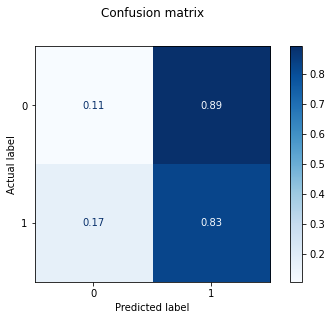

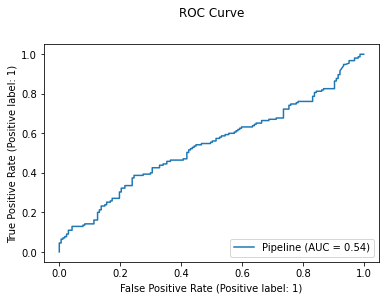

In [39]:
classify_cv(df, 'binary')

## Histogram of true traits

In [ ]:
def check_imbalance(df, traits):
    length = len(df)
    o = df['traits', 'openn']
    c = df['traits', 'consc']
    e = df['traits', 'extra']
    a = df['traits', 'agree']
    n = df['traits', 'neuro']
    binarylst = [o, c, e, a, n]
    o5 = df['traits', 'openn5']
    c5 = df['traits', 'consc5']
    e5 = df['traits', 'extra5']
    a5 = df['traits', 'agree5']
    n5 = df['traits', 'neuro5']
    multilst = [o5, c5, e5, a5, n5]
    
    result = []
    for trait in binarylst: 
        result.append(np.bincount(trait) / length)
    result5 = []
    for trait in multilst:
        result5.append(np.bincount(trait) / len(trait))
    
    print("Distribution of the true trait values in the classes (in %):\n")
    for i in range(len(traits)):
        print(traits[i], "\n\tBinary: ", result[i], "\n\t5 classes: ", result5[i], "\n")
    
#     result =np.bincount(o) / len(o)
#     result5 =np.bincount(o5) / len(o)
#     print("Openness\n\tBinary: ", result, "\n\t5 classes: ", result5)

    
check_imbalance(df, traits)

In [ ]:
# true histogram plots
all_hist_true(df)

In [ ]:
# %%javascript
# IPython.OutputArea.auto_scroll_threshold = 1000;

### check results on train set with k nearest neighbor algorithm

In [ ]:
classify(df, 'knn', 'binary', trainscores=True, plotting=False, weighted=False, detailed=False)

In [ ]:
classify(df, 'knn', 'multi', trainscores=True, plotting=False, weighted=False, detailed=False)

### Logistic regression

In [ ]:
classify(df, 'log', 'binary', plotting=True)

In [ ]:
classify(df, 'log', 'binary', plotting=True, weighted=True)

### Logistic Regression: multiclass

In [ ]:
classify(df, 'multilog', 'multi', plotting=True, weighted=True, detailed=False)

### MLP

In [ ]:
classify(df, 'mlp', 'binary', plotting=True)

In [ ]:
classify(df, 'mlp', 'multi', plotting=True)

### SVM

In [ ]:
classify(df, 'svm', 'binary', plotting=True)

In [ ]:
classify(df, 'svm', 'multi', plotting=True)

In [ ]:
classify(df, 'svmlinear', 'linear', plotting=True)

### Linear Regression

In [ ]:
classify(df, 'linear', 'linear', plotting=True)

# Results without predictor subreddit

###  binary log (without subreddit)

In [ ]:
classify(smalldf, 'log', 'binary', plotting=True, weighted=True, detailed=False)

### multi log (without subreddit)

In [ ]:
classify(smalldf, 'multilog', 'multi', plotting=True, weighted=True, detailed=False)

### MLP (without subreddit)

In [ ]:
classify(smalldf, 'mlp', 'binary', plotting=True, weighted=False, detailed=False)

### Linear Regression (without subreddit)

In [ ]:
classify(smalldf, 'lin', 'linear', plotting=True)